<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">TFM - Previsión de demanda mediante uso de técnicas de machine learning
</p>
<p style="margin: 0; text-align:right;">Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Carlos Pérez Cebrián</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

### Deep Learning

Aplicación de un modelo de Deep Learning para predecir la demanda de productos en función de una serie de factores contextuales y temporales. 
Compuesto por múltiples capas para aprender características complejas y de alto nivel directamente desde los datos sin necesidad de ingeniería manual de características. 

Finalmente se evalua su eficiencia con el calculo de métricas MSE, MAE y R².

Estructura del modelo
1. Capa de Entrada:
El modelo recibe múltiples características como entrada: variables numéricas (media_X_dias y venta_lag_X_dias) y categóricas (producto, abierto/cerraod, EsPromoción...)

2. Capas Ocultas:
- Capa dense_3 (con 128 neuronas): Es una capa totalmente conectada que transforma las características de entrada a un espacio de 128 dimensiones.
- Capa dropout_2 (Dropout de 50%): Ayuda a prevenir el sobreajuste desactivando aleatoriamente el 50% de las neuronas durante el entrenamiento.
- Capa dense_4 (con 64 neuronas): Otra capa densa que reduce la dimensionalidad antes de la capa de salida.
- Capa dropout_3 (Dropout de 50%): Similar a la anterior, ayuda a prevenir el sobreajuste.

3. Capa de Salida:
La capa final que produce una sola predicción, en este caso, el número de unidades vendidas (udsVenta).

4. Optimización y Función de Pérdida:
El modelo utiliza el descenso de gradiente para minimizar la función de pérdida.
La función de activación en las capas ocultas es ReLU, lo que permite que el modelo aprenda relaciones no lineales.


Cargamos las siguientes librerías necesarias:

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler #transformación variables (onehot:pocas categorias; label:ordinal)
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score #métricas
import matplotlib.pyplot as plt

Cargar el conjunto de dato

(Nota: el conjunto de datos es el resultado de una fase de exploración, analisis y preparación previa.)

In [2]:
# Cargar el archivo CSV con los datos de ventas
file_path = "Data/VentasRdo.csv"
file_path = "Data/VentasRdo_10productos.csv"
df = pd.read_csv(file_path, parse_dates=['idSecuencia'])

# Variables independientes y dependientes
X = df[['producto', 'bolOpen', 'EnPromocion', 'anyomes', 'diasemana', 'semana', 
        'media_7_dias', 'media_30_dias', 'venta_lag_1', 'venta_lag_7', 'venta_lag_30']]
y = df["udsVenta"]

# Transformar variables categóricas y escalar
preprocessor = ColumnTransformer(transformers=[
    ("num", StandardScaler(), ['anyomes', 'media_7_dias', 'media_30_dias', 'venta_lag_1', 'venta_lag_7', 'venta_lag_30']),
    ("cat", OneHotEncoder(drop="first"), ['producto', 'bolOpen', 'EnPromocion', 'diasemana', 'semana'])
], remainder='passthrough')

X_processed = preprocessor.fit_transform(X)

Definir las características (X) y la variable objetivo (y)

In [3]:
# Dividir el conjunto de datos en entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

print(f"Dimensiones de X_train: {X_train.shape}, X_test: {X_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}")

Dimensiones de X_train: (5608, 74), X_test: (1402, 74), y_train: (5608,), y_test: (1402,)


In [4]:
# modelo
model = Sequential([
    Input(shape=(X_processed.shape[1],)),
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='linear')  # Activación lineal para regresión
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
model.summary()


C:\Users\carpe\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         9,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,921 (70.00 KB)

 Trainable params: 17,921 (70.00 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Entrenar el modelo
history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=64, verbose=1)

Epoch 1/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 1.3989 - mae: 0.9639 - val_loss: 0.5910 - val_mae: 0.6243
Epoch 2/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6356 - mae: 0.6505 - val_loss: 0.5450 - val_mae: 0.5868
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5870 - mae: 0.6155 - val_loss: 0.5326 - val_mae: 0.5747
Epoch 4/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5697 - mae: 0.6067 - val_loss: 0.5280 - val_mae: 0.5695
Epoch 5/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5423 - mae: 0.5864 - val_loss: 0.5216 - val_mae: 0.5648
Epoch 6/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5258 - mae: 0.5778 - val_loss: 0.5267 - val_mae: 0.5698
Epoch 7/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5192 - mae: 0.5731 - val_loss: 0.5195 - val_mae: 0.5638
Epoch 8/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5033 - mae: 0.5612 - val_loss: 0.5228 - val_mae: 0.5678
Epoch 9/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.4915 - mae:

In [6]:
# Evaluar en el conjunto de prueba
y_pred = model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse},MSE: {mse}, MAE: {mae}, R2: {r2}")

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
RMSE: 0.7523923964148559,MSE: 0.5660943181828897, MAE: 0.5738483647540942, R2: 0.4548117399862509


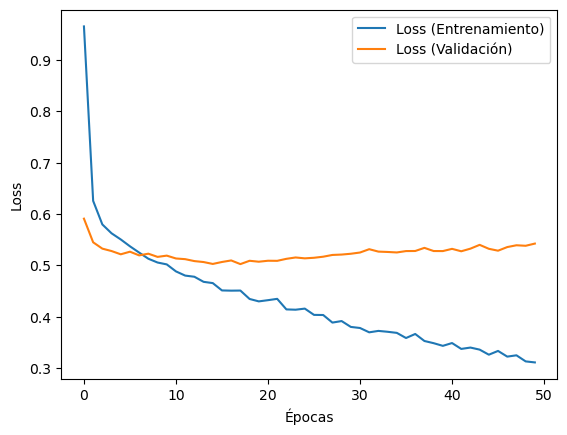

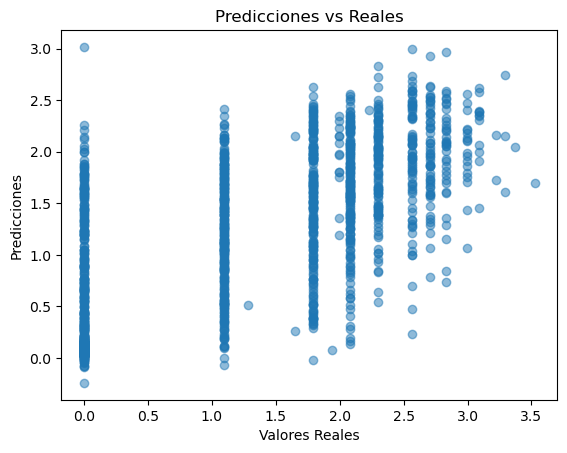

In [7]:
# Gráfica del aprendizaje
plt.plot(history.history['loss'], label='Loss (Entrenamiento)')
plt.plot(history.history['val_loss'], label='Loss (Validación)')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Comparar predicciones vs valores reales
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Reales')
plt.show()

El modelo parece estar aprendiendo correctamente, ya que el MAE disminuye a medida que avanza el entrenamiento, pero, al observar los datos sobre la validación, ha sobreajustado un poco .